In [1]:
from GMMflow_main import *
import matplotlib.pyplot as plt
from third_party.plot_confidence_region import * 
from sklearn.mixture import GaussianMixture
import matplotlib.colors as mcolors

In [2]:
device = 'cuda' # or 'cpu' if cuda is not available. 

GTsamples = 10*torch.tensor(np.loadtxt('GTsamples.txt'), dtype=torch.float32) # Get data from the GT distribution 
DCSLsamples = 10*torch.tensor(np.loadtxt('DCSLsamples.txt'), dtype=torch.float32) # Get data from the DCSL distribution 

GTsamples = GTsamples - GTsamples.mean(dim=0)
DCSLsamples = DCSLsamples - DCSLsamples.mean(dim=0)

In [3]:
rho0 = GaussianMixture(n_components=100, covariance_type='diag').fit(GTsamples) # fit some GMMs
rho1 = GaussianMixture(n_components=100, covariance_type='diag').fit(DCSLsamples)

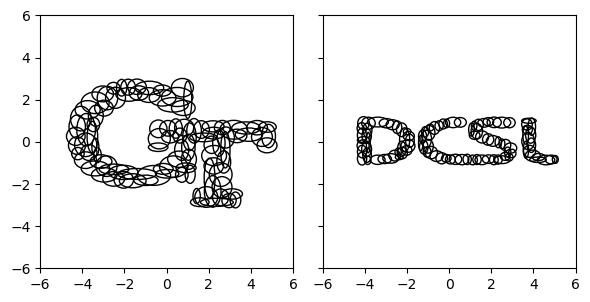

In [4]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True) # Check the GMMs look ok
fig.set_size_inches(6, 6)

for mu, s in zip(rho0.means_, rho0.covariances_):
    confidence_ellipse(ax[0], cov=np.eye(2)*s, mean=mu, edgecolor='k')
    ax[0].set_aspect('equal')
    ax[0].set_xlim([-6,6])
    ax[0].set_ylim([-6,6])
for mu, s in zip(rho1.means_, rho1.covariances_):
    confidence_ellipse(ax[1], cov=np.eye(2)*s, mean=mu, edgecolor='k')
    ax[1].set_aspect('equal')
Mu0 = torch.tensor(rho0.means_, dtype=torch.float32, device=device)
Sigma0 = torch.tensor(rho0.covariances_, dtype=torch.float32, device=device)
W0 = torch.tensor(rho0.weights_, dtype=torch.float32, device=device)

Mu1 = torch.tensor(rho1.means_, dtype=torch.float32, device=device)
Sigma1 = torch.tensor(rho1.covariances_, dtype=torch.float32, device=device)
W1 = torch.tensor(rho1.weights_, dtype=torch.float32, device=device)

In [5]:
sde = GMMflow(Mu0, Mu1, Sigma0, Sigma1, W0, W1, epsilon=np.sqrt(0.1), device=device) # defines our SDE. The optimal transport plan will be calculated automatically (no training needed!)

In [6]:
x0 = GTsamples[0:2000, :].to(device) # Get some initial conditions from the GT distribution.
ts = torch.linspace(0, 1., 51).to(device) # get the SDE values at these points for visualization. 
y = torchsde.sdeint(sde, x0, ts, dt=0.01) # integrate the policy 

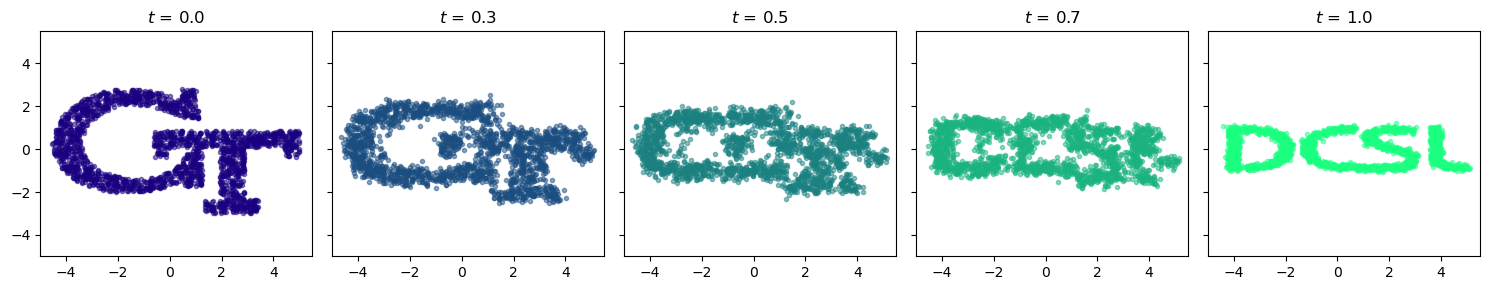

In [7]:
fig, axs = plt.subplots(1, 5, sharey=True, sharex=True, tight_layout=True) # plot the results! 
fig.set_size_inches(15, 3)
k_plot= [0, 15, 25, 35, 50]
for k, ax in zip(k_plot, axs):
    ax.plot(y[k, :, 0].cpu(), y[k, :, 1].cpu(), '.', color=(0.1, k/50, 0.5, 0.5))
    ax.set_xlim([-5, 5.5])
    ax.set_ylim([-5, 5.5])
    ax.set_title('$t$ = '+ str(k/50))

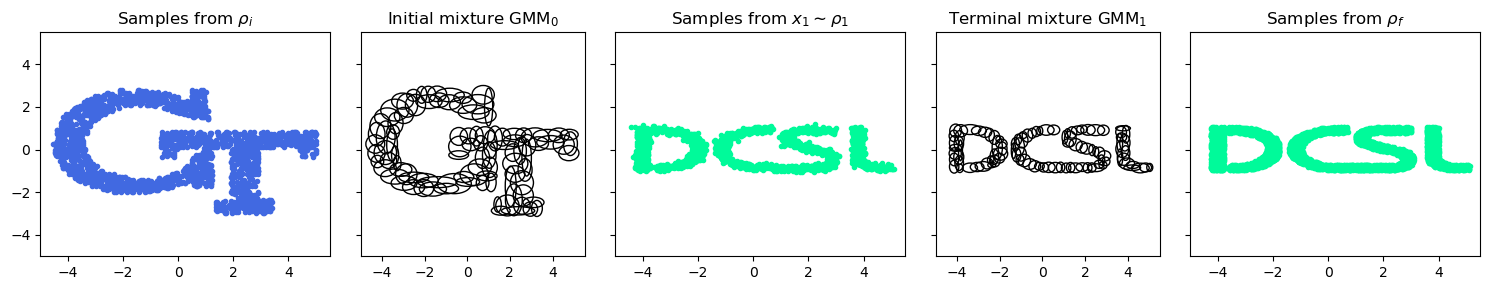

In [8]:
fig, ax = plt.subplots(1, 5, sharey=True, sharex=True, tight_layout=True)
fig.set_size_inches(15, 3)

grn = mcolors.CSS4_COLORS['mediumspringgreen']
blue = mcolors.CSS4_COLORS['royalblue']

ax[0].plot(y[0, :, 0].cpu(), y[0, :, 1].cpu(), '.', color=blue)
ax[0].set_xlim([-5, 5.5])
ax[0].set_ylim([-5, 5.5])
ax[0].set_title(r'Samples from $\rho_i$')

for mu, s in zip(rho0.means_, rho0.covariances_):
    confidence_ellipse(ax[1], cov=np.eye(2)*s, mean=mu, edgecolor='k')
    ax[1].set_aspect('equal')
    ax[1].set_xlim([-5,5.5])
    ax[1].set_ylim([-5,5.5])
    ax[1].set_title(r'Initial mixture $\mathrm{GMM}_0$')

ax[2].plot(y[-1, :, 0].cpu(), y[-1, :, 1].cpu(), '.', color=grn)
ax[2].set_xlim([-5, 5.5])
ax[2].set_ylim([-5, 5.5])
ax[2].set_title(r'Samples from $x_1\sim\rho_1$')

for mu, s in zip(rho1.means_, rho1.covariances_):
    confidence_ellipse(ax[3], cov=np.eye(2)*s, mean=mu, edgecolor='k')
    ax[3].set_aspect('equal')
    ax[3].set_title(r'Terminal mixture $\mathrm{GMM}_1$')
    
ax[4].plot(DCSLsamples[:, 0].cpu(), DCSLsamples[:, 1].cpu(), '.', color=grn)
ax[4].set_xlim([-5, 5.5])
ax[4].set_ylim([-5, 5.5])
ax[4].set_title(r'Samples from $\rho_f$');

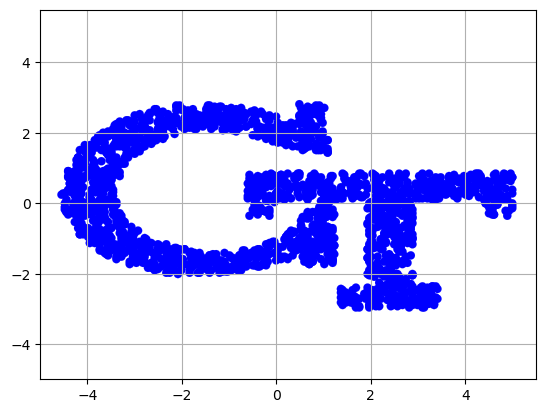

In [9]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
data = torch.concat([y[0, :].repeat(10, 1, 1), y, y[-1, :].repeat(10, 1, 1)], dim =0) # add some time at t=0, t=1
data = data.detach().cpu().numpy()
scat = ax.scatter(data[0, :, 0], data[0, :, 1], c="b", linewidth =0.1*np.ones(data.shape[0]))

ax.set(xlim=[-5, 5.5], ylim=[-5,5.5])
ax.grid('on')

def update(frame):
    # for each frame, update the data stored on each artist.
    # if frame > 1:
    #     mu = data[:, 0:2, 0:frame].mean(dim=0)
    #     ax.plot(mu[0, :], mu[1, :], 'k')
    
    pointCloud = np.stack([data[frame, :,0], data[frame, :, 1]]).T
    scat.set_offsets(pointCloud)
    return scat

ani = animation.FuncAnimation(fig=fig, func=update, frames=data.shape[0], interval=100)
plt.show()
ani.save(filename="figures/GT2DCSL.gif", writer="pillow")